# Nettverksanalyse i sgis
https://github.com/statisticsnorway/ssb-sgis

Notebook-en kan kjøres i dapla hvis man har tilgang til bøtta 'kart'.

Eller åpnes her: https://nbviewer.org/github/statisticsnorway/intro_til_geopandas/blob/main/nettverksanalyse.ipynb

Innhold:
- Klargjøre vegdata for nettverksanalyse
- get_route_frequency: Tell opp antall ganger hver veg blir brukt
- service_area: Finn området som kan nås innen gitte reisetider
- od_cost_matrix: Rask beregning av reisetid fra start- til sluttpunkter
- get_route: Finn raskeste rute(r) fra A til B

In [1]:
# for å installere, kjør i terminalen:
# poetry add ssb-sgis

In [2]:
import numpy as np
import sgis as sg

## Hente vegdata

Henter vegdata for 2022 i Oslo og to nabokommuner (Bærum og Nordre Follo).

Velger også kun relevante kolonner for dette formålet: retning og kjøretid.

In [3]:
kartdata = "ssb-prod-kart-data-delt/kartdata_analyse/klargjorte-data"

veger = (
    sg.read_geopandas(
        f"{kartdata}/2022/NVDB_ruteplan_nettverk_p20220703_v1.parquet",
        filters=[("KOMMUNENR", "in",  ("0301", "3024", "3020"))],
        columns=["oneway", "drivetime_fw", "drivetime_bw", "geometry"]
    )
    .sort_values("oneway")
    .reset_index(drop=True)
)

veger

oneway  drivetime_fw  drivetime_bw  \
0           B      0.216611      0.216611   
1           B      0.062602      0.062602   
2           B      0.053945      0.053945   
3           B      0.135625      0.135625   
4           B      0.111156      0.111156   
...       ...           ...           ...   
119295     TF     -1.000000      0.101898   
119296     TF     -1.000000      0.019263   
119297     TF     -1.000000      0.005270   
119298     TF     -1.000000      0.028626   
119299     TF     -1.000000      0.092640   

                                                 geometry  
0       MULTILINESTRING Z ((258028.440 6674249.890 413...  
1       MULTILINESTRING Z ((265347.560 6654750.570 230...  
2       MULTILINESTRING Z ((268027.000 6646538.600 160...  
3       MULTILINESTRING Z ((262066.673 6655401.898 212...  
4       MULTILINESTRING Z ((268124.331 6646443.504 160...  
...                                                   ...  
119295  MULTILINESTRING Z ((263061.100 6651519.800 55....  
119296  MULTILINESTRING Z ((247488.922 6649695.927 26....  
119297  MULTILINESTRING Z ((247490.918 6649692.213 26....  
119298  MULTILINESTRING Z ((248167.570 6649285.687 31....  
119299  MULTILINESTRING Z ((265986.345 6627160.435 125...  

[119300 rows x 4 columns]

## Gjør klar til nettverksanalyse

Starter med å definere noen regler for analysene.

Her vil jeg beregne kjøretid med bil. Setter derfor vekt-kolonnen til "minutes" og directed til True (som betyr at man bare kan bevege seg i én retning langs vegene).

In [4]:
regler = sg.NetworkAnalysisRules(
    weight="minutes",
    directed=True,
    search_tolerance=500, # meter
)
regler

NetworkAnalysisRules(directed=True, weight='minutes', search_tolerance=500, search_factor=0, split_lines=False, nodedist_multiplier=None, nodedist_kmh=None)

For å få et vegnett der alle veger går i riktig retning, må man snu vegene som går i motsatt/begge retning(er).

In [5]:
antall_per_retning = veger.oneway.value_counts().to_frame()

antall_per_retning["hva_må_gjøres"] = {"B": "Duplisere og snu duplikatene", "TF": "Snu", "FT": "Ingenting"}

antall_per_retning

oneway                 hva_må_gjøres
B   102631  Duplisere og snu duplikatene
FT   10924                     Ingenting
TF    5745                           Snu

Og man må lage en felles minutt-kolonne av kjøretid-kolonnene.

In [6]:
veger[["oneway", "drivetime_fw", "drivetime_bw"]]

oneway  drivetime_fw  drivetime_bw
0           B      0.216611      0.216611
1           B      0.062602      0.062602
2           B      0.053945      0.053945
3           B      0.135625      0.135625
4           B      0.111156      0.111156
...       ...           ...           ...
119295     TF     -1.000000      0.101898
119296     TF     -1.000000      0.019263
119297     TF     -1.000000      0.005270
119298     TF     -1.000000      0.028626
119299     TF     -1.000000      0.092640

[119300 rows x 3 columns]

Dette kan gjøres sånn her:

In [7]:
veger_med_retning = sg.make_directed_network_norway(veger)
veger_med_retning

oneway   minutes                                           geometry
0           B  0.216611  MULTILINESTRING Z ((258028.440 6674249.890 413...
1           B  0.062602  MULTILINESTRING Z ((265347.560 6654750.570 230...
2           B  0.053945  MULTILINESTRING Z ((268027.000 6646538.600 160...
3           B  0.135625  MULTILINESTRING Z ((262066.673 6655401.898 212...
4           B  0.111156  MULTILINESTRING Z ((268124.331 6646443.504 160...
...       ...       ...                                                ...
221926     TF  0.101898  MULTILINESTRING Z ((263009.600 6651564.100 54....
221927     TF  0.019263  MULTILINESTRING Z ((247482.167 6649709.778 26....
221928     TF  0.005270  MULTILINESTRING Z ((247488.922 6649695.927 26....
221929     TF  0.028626  MULTILINESTRING Z ((248151.801 6649269.396 31....
221930     TF  0.092640  MULTILINESTRING Z ((265966.376 6627206.697 126...

[221827 rows x 3 columns]

Eller en mer generell variant:

In [8]:
veger_med_retning = sg.make_directed_network(
    veger,
    direction_col="oneway",
    direction_vals_bft=("B", "FT", "TF"),
    minute_cols=("drivetime_fw", "drivetime_bw"),
)

veger_med_retning

oneway   minutes                                           geometry
0           B  0.216611  MULTILINESTRING Z ((258028.440 6674249.890 413...
1           B  0.062602  MULTILINESTRING Z ((265347.560 6654750.570 230...
2           B  0.053945  MULTILINESTRING Z ((268027.000 6646538.600 160...
3           B  0.135625  MULTILINESTRING Z ((262066.673 6655401.898 212...
4           B  0.111156  MULTILINESTRING Z ((268124.331 6646443.504 160...
...       ...       ...                                                ...
221926     TF  0.101898  MULTILINESTRING Z ((263009.600 6651564.100 54....
221927     TF  0.019263  MULTILINESTRING Z ((247482.167 6649709.778 26....
221928     TF  0.005270  MULTILINESTRING Z ((247488.922 6649695.927 26....
221929     TF  0.028626  MULTILINESTRING Z ((248151.801 6649269.396 31....
221930     TF  0.092640  MULTILINESTRING Z ((265966.376 6627206.697 126...

[221827 rows x 3 columns]

In [9]:
print("Kilometer før:", veger.length.sum() / 1000)
print("Kilometer nå:", veger_med_retning.length.sum() / 1000)

Kilometer før: 5663.95873677671
Kilometer nå: 10705.69080730138


In [10]:
veger_med_retning.minutes

0         0.216611
1         0.062602
2         0.053945
3         0.135625
4         0.111156
            ...   
221926    0.101898
221927    0.019263
221928    0.005270
221929    0.028626
221930    0.092640
Name: minutes, Length: 221827, dtype: float64

Man bør også fjerne isolerte nettverksøyer. Dette er gjerne veger bak bommer (innkjørsler, inni borettslag).

Sånn her kan man finne og fjerne nettverksøyene:

In [11]:
veger_ned_tilknytning = sg.get_connected_components(veger_med_retning).query("connected == 1")
veger_ned_tilknytning

oneway   minutes                                           geometry  \
1           B  0.062602  LINESTRING Z (265347.560 6654750.570 230.981, ...   
2           B  0.053945  LINESTRING Z (268027.000 6646538.600 160.863, ...   
3           B  0.135625  LINESTRING Z (262066.673 6655401.898 212.598, ...   
4           B  0.111156  LINESTRING Z (268124.331 6646443.504 160.221, ...   
5           B  0.042334  LINESTRING Z (267727.700 6646980.000 181.563, ...   
...       ...       ...                                                ...   
221926     TF  0.101898  LINESTRING Z (263009.600 6651564.100 54.560, 2...   
221927     TF  0.019263  LINESTRING Z (247482.167 6649709.778 26.419, 2...   
221928     TF  0.005270  LINESTRING Z (247488.922 6649695.927 26.548, 2...   
221929     TF  0.028626  LINESTRING Z (248151.801 6649269.396 31.281, 2...   
221930     TF  0.092640  LINESTRING Z (265966.376 6627206.697 126.538, ...   

        connected  
1             1.0  
2             1.0  
3             1.0  
4             1.0  
5             1.0  
...           ...  
221926        1.0  
221927        1.0  
221928        1.0  
221929        1.0  
221930        1.0  

[204464 rows x 4 columns]

In [12]:
print("Kilometer før:", veger_med_retning.length.sum() / 1000)
print("Kilometer nå:", veger_ned_tilknytning.length.sum() / 1000)

Kilometer før: 10705.69080730138
Kilometer nå: 9522.320634061576


In [13]:
sg.samplemap(veger_med_retning, veger_ned_tilknytning)

Nå er vegene klare for nettverksanalyse:

In [14]:
nwa = sg.NetworkAnalysis(network=veger_ned_tilknytning, rules=regler)
nwa

NetworkAnalysis(
    network=Network(9522 km, percent_bidirectional=85),
    rules=NetworkAnalysisRules(weight=minutes, directed=True, search_tolerance=500, search_factor=0, split_lines=False, ...),
    log=True, detailed_log=False,
)

### Først en liten test av retning
La oss teste at retningen lages riktig.

Sjekker at tur-retur Vippetangen-Ryen går i riktige tunnelløp.

In [16]:
vippetangen = sg.to_gdf([10.741527, 59.9040595], crs=4326).to_crs(veger.crs)
ryen = sg.to_gdf([10.8047522, 59.8949826], crs=4326).to_crs(veger.crs)

OBS: Å beregne én rute av gangen går mye treigere enn å beregne mange samtidig.

In [17]:
ryen_til_vippa = nwa.get_route(ryen, vippetangen)
vippa_til_ryen = nwa.get_route(vippetangen, ryen)
sg.explore(ryen_til_vippa, vippa_til_ryen)

Nå litt skikkelig analyse. Henter bygningspunkter.

In [19]:
bygningspunktsti = f"ssb-prod-kart-data-delt/kartdata_analyse/klargjorte-data/2022/SMAT_bygg_punkt_p2022_v1.parquet"

bygg = sg.read_geopandas(
    bygningspunktsti,
    filters=[("KOMMUNENR", "in",  ("0301", "3024", "3020"))],
    columns=["KOMMUNENR", "geometry"]
)
bygg

KOMMUNENR                        geometry
2126288      3020  POINT (269263.000 6617407.000)
2126460      3020  POINT (267831.000 6616413.000)
2126732      3020  POINT (270268.000 6617244.000)
2126740      3020  POINT (268989.000 6617320.000)
2126749      3020  POINT (269058.000 6617321.000)
...           ...                             ...
2704094      0301  POINT (258558.000 6667933.000)
2704589      0301  POINT (258492.000 6667941.000)
2704605      0301  POINT (258532.000 6668042.000)
2704777      0301  POINT (256610.000 6668631.000)
2704846      0301  POINT (256158.000 6668920.000)

[218821 rows x 2 columns]

## Finn rutefrekvens
Finner antall ganger hver veg blir brukt fra 100 til 100 punkter, altså 10 000 reiser til sammen.

In [43]:
utvalg = bygg.query("KOMMUNENR == '0301'").sample(100)

frequencies = nwa.get_route_frequencies(
    origins=utvalg,
    destinations=utvalg,
)

frequencies.nlargest(3, "frequency")

oneway   minutes  connected  idx_orig  \
194497     FT  0.005000        1.0    211900   
194511     FT  0.006661        1.0    211914   
194496     FT  0.011319        1.0    211899   

                                 source_wkt  \
194497  POINT (265359.5999999996 6647135.4)   
194511  POINT (265371.4000000004 6647147.9)   
194496  POINT (265362.7999999998 6647137.1)   

                                 target_wkt source target  n_source  n_target  \
194497  POINT (265362.7999999998 6647137.1)  95963  93161         3         3   
194511           POINT (265372.5 6647152.6)  95973  95637         3         3   
194496  POINT (265368.5999999996 6647142.9)  93161  95962         3         2   

          meters  frequency                                           geometry  
194497  3.623534     1402.0  LINESTRING Z (265359.600 6647135.400 131.660, ...  
194511  4.827007     1390.0  LINESTRING Z (265371.400 6647147.900 131.660, ...  
194496  8.202439     1266.0  LINESTRING Z (265362.800 6647137.100 131.660, ...

Kartlegg resultatene.

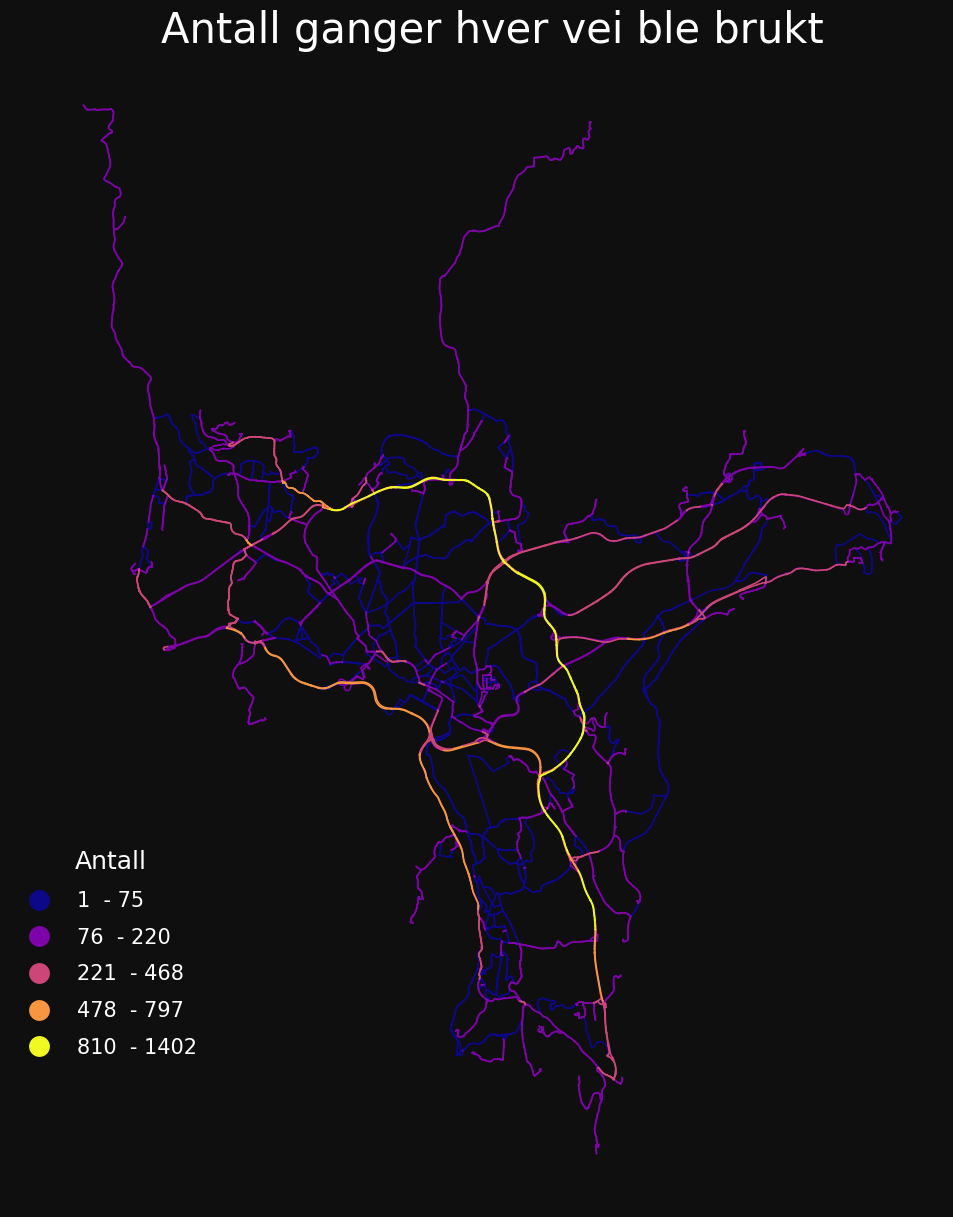

In [44]:
m = sg.ThematicMap(sg.buff(frequencies, 18), column="frequency", size=15)
m.black = True
m.cmap = "plasma" # fargepaletten
m.title = "Antall ganger hver vei ble brukt"
m.legend.title = "Antall"
m.plot()

### Service area

Finner veiene som kan nås innen 1 til 10 minutter fra et tilfeldig bygg. 

In [45]:
service_areas = nwa.service_area(
    bygg.sample(1),
    breaks=np.arange(1, 11),
)

service_areas

origin  minutes                                           geometry
0  2499573        1  MULTILINESTRING Z ((253800.960 6651170.200 84....
1  2499573        2  MULTILINESTRING Z ((253909.800 6651611.300 92....
2  2499573        3  MULTILINESTRING Z ((254101.140 6652120.750 113...
3  2499573        4  MULTILINESTRING Z ((254967.020 6652166.780 115...
4  2499573        5  MULTILINESTRING Z ((252391.446 6650097.344 54....
5  2499573        6  MULTILINESTRING Z ((256243.700 6651533.900 84....
6  2499573        7  MULTILINESTRING Z ((256422.540 6652222.560 117...
7  2499573        8  MULTILINESTRING Z ((256389.996 6652077.502 103...
8  2499573        9  MULTILINESTRING Z ((258673.757 6652325.383 62....
9  2499573       10  MULTILINESTRING Z ((258797.958 6651962.408 48....

In [ ]:
m = sg.ThematicMap(service_areas, column="minutes", size=15)
m.black = True
m.k = 10
m.title = "Veier som kan nås fra 1 adresse innen ett til ti minutter"
m.legend = False
m.plot()

Sjekke loggen:

In [24]:
nwa.log

endtime  minutes_elapsed                 method  origins_count  \
0 2023-04-20 22:09:43              0.1              get_route              1   
1 2023-04-20 22:09:50              0.1              get_route              1   
2 2023-04-20 22:10:57              0.4  get_route_frequencies            100   
3 2023-04-20 22:11:11              0.1           service_area              1   

   destinations_count  percent_missing  cost_mean  percent_bidirectional  
0                 1.0              0.0   6.354152                     85  
1                 1.0              0.0   5.357292                     85  
2               100.0              0.0   0.082112                     85  
3                 NaN              0.0   5.500000                     85

### Reisetider: OD Cost Matrix

Lager start- og sluttpunkter.

In [25]:
origins = bygg.sample(1000)
origins.index = np.arange(0, 1000)
origins

KOMMUNENR                        geometry
0        3020  POINT (265042.000 6632105.000)
1        3024  POINT (248455.000 6653297.000)
2        0301  POINT (260955.000 6650145.000)
3        3024  POINT (246722.000 6647020.000)
4        3024  POINT (252295.000 6648578.000)
..        ...                             ...
995      0301  POINT (263437.000 6654232.000)
996      0301  POINT (271995.000 6651908.000)
997      0301  POINT (263614.000 6651803.000)
998      3024  POINT (249035.000 6647154.000)
999      3024  POINT (253991.000 6649893.000)

[1000 rows x 2 columns]

In [26]:
destinations = bygg.sample(1000)
destinations.index = np.arange(1000, 2000)
destinations

KOMMUNENR                        geometry
1000      0301  POINT (256228.000 6656433.000)
1001      0301  POINT (258615.000 6651358.000)
1002      3024  POINT (251652.000 6651449.000)
1003      3024  POINT (253986.000 6650534.000)
1004      3024  POINT (252141.000 6650006.000)
...        ...                             ...
1995      0301  POINT (270167.000 6654887.000)
1996      0301  POINT (265216.000 6654818.000)
1997      3020  POINT (265572.000 6632900.000)
1998      3024  POINT (253287.000 6648470.000)
1999      0301  POINT (257729.000 6654722.000)

[1000 rows x 2 columns]

Og beregner reisetiden.

In [27]:
od = nwa.od_cost_matrix(
    origins,
    destinations,
)
od

origin  destination    minutes
0            0         1000  36.495332
1            0         1001  25.050956
2            0         1002  36.522361
3            0         1003  31.355475
4            0         1004  32.831649
...        ...          ...        ...
999995     999         1995  27.311472
999996     999         1996  23.603070
999997     999         1997  34.760951
999998     999         1998   7.424332
999999     999         1999  17.234761

[1000000 rows x 3 columns]

Sjekk hvor mange prosent som mangler:

In [28]:
od.minutes.isna().mean() * 100

2.6817

Kolonnene 'origin' og 'destination' bruker index-en til inputene.

Man kan derfor enkelt koble resultatene med start- og sluttpunktene:

In [29]:
origins_joinet = origins.join(od.set_index("origin"))
origins_joinet

KOMMUNENR                        geometry  destination    minutes
0        3020  POINT (265042.000 6632105.000)         1000  36.495332
0        3020  POINT (265042.000 6632105.000)         1001  25.050956
0        3020  POINT (265042.000 6632105.000)         1002  36.522361
0        3020  POINT (265042.000 6632105.000)         1003  31.355475
0        3020  POINT (265042.000 6632105.000)         1004  32.831649
..        ...                             ...          ...        ...
999      3024  POINT (253991.000 6649893.000)         1995  27.311472
999      3024  POINT (253991.000 6649893.000)         1996  23.603070
999      3024  POINT (253991.000 6649893.000)         1997  34.760951
999      3024  POINT (253991.000 6649893.000)         1998   7.424332
999      3024  POINT (253991.000 6649893.000)         1999  17.234761

[1000000 rows x 4 columns]

In [30]:
destinations_joinet = destinations.join(od.set_index("destination"))
destinations_joinet

KOMMUNENR                        geometry  origin    minutes
1000      0301  POINT (256228.000 6656433.000)       0  36.495332
1000      0301  POINT (256228.000 6656433.000)       1  22.303396
1000      0301  POINT (256228.000 6656433.000)       2  16.470821
1000      0301  POINT (256228.000 6656433.000)       3  27.318576
1000      0301  POINT (256228.000 6656433.000)       4  19.524729
...        ...                             ...     ...        ...
1999      0301  POINT (257729.000 6654722.000)     995  11.227849
1999      0301  POINT (257729.000 6654722.000)     996  22.141335
1999      0301  POINT (257729.000 6654722.000)     997  14.335213
1999      0301  POINT (257729.000 6654722.000)     998  22.957843
1999      0301  POINT (257729.000 6654722.000)     999  17.234761

[1000000 rows x 4 columns]

Eller koble på aggregert data:

In [31]:
origins["minutes_mean"] = od.groupby("origin").minutes.mean()
origins["n_missing"] = len(origins) - od.groupby("origin", dropna=False).minutes.count()
origins

KOMMUNENR                        geometry  minutes_mean  n_missing
0        3020  POINT (265042.000 6632105.000)     23.777353         13
1        3024  POINT (248455.000 6653297.000)     28.674081         13
2        0301  POINT (260955.000 6650145.000)     16.892150         13
3        3024  POINT (246722.000 6647020.000)     26.886734         13
4        3024  POINT (252295.000 6648578.000)     20.328249         13
..        ...                             ...           ...        ...
995      0301  POINT (263437.000 6654232.000)     17.556836         13
996      0301  POINT (271995.000 6651908.000)     21.998150         13
997      0301  POINT (263614.000 6651803.000)     17.462155         13
998      3024  POINT (249035.000 6647154.000)     24.520311         13
999      3024  POINT (253991.000 6649893.000)     20.292126         13

[1000 rows x 4 columns]

La oss undersøke hvilke punkter som har mye manglende data. 

In [32]:
# gjør kolonnen til tekst for å kunne huke av/på verdiene i explore
origins["n_missing_cat"] = origins.n_missing.astype(str)
sg.explore(origins, column="n_missing_cat")

In [33]:
sg.explore(origins, column="minutes_mean", scheme="quantiles")

Hvis man vil bruke en kolonne som id-er heller enn index-en, kan man sette index-en inni funksjonen.

In [34]:
od = nwa.od_cost_matrix(
    origins.set_index("KOMMUNENR"),
    destinations,
)

od

origin  destination    minutes
0        3020         1000  36.495332
1        3020         1001  25.050956
2        3020         1002  36.522361
3        3020         1003  31.355475
4        3020         1004  32.831649
...       ...          ...        ...
999995   3024         1995  27.311472
999996   3024         1996  23.603070
999997   3024         1997  34.760951
999998   3024         1998   7.424332
999999   3024         1999  17.234761

[1000000 rows x 3 columns]

Så kan man oppsummere for kommunene direkte:

In [35]:
oppsummert_kommunevis = od.groupby("origin").agg(
    minutes_mean=("minutes", "mean"),
    count=("minutes", "count"),
)

oppsummert_kommunevis.index.name = "KOMMUNENR"
oppsummert_kommunevis.reset_index()

KOMMUNENR  minutes_mean   count
0      0301     20.010196  595162
1      3020     28.204705  143115
2      3024     22.623926  234906

Med lines=True får man rette linjer, så man lettere kan undersøke resultatene.

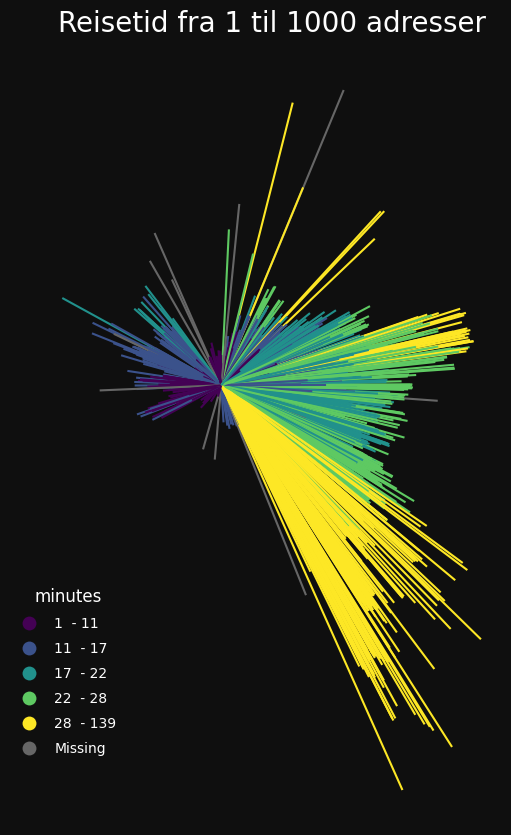

In [36]:
od = nwa.od_cost_matrix(
    origins.sample(1),
    destinations,
    lines=True
)

m = sg.ThematicMap(od, column="minutes", size=10)
m.black = True
m.title = "Reisetid fra 1 til 1000 adresser"
m.scheme = "quantiles"
m.plot()

## Finn raskeste rute
Velger ett startpunkt for illustrasjons skyld.

In [37]:
origin = bygg.loc[[2_470_929]]

In [38]:
routes = nwa.get_route(
    origins=origin,
    destinations=destinations.sample(15),
)

routes

origin  destination    minutes  \
0   2470929         1225  16.088010   
1   2470929         1703  26.049475   
2   2470929         1641  14.734904   
3   2470929         1340  13.003589   
4   2470929         1019   9.073945   
5   2470929         1796  12.671446   
6   2470929         1847  21.641302   
7   2470929         1250  13.839811   
8   2470929         1782  16.267564   
9   2470929         1209  17.118274   
10  2470929         1233   5.860294   
11  2470929         1401  14.636791   
12  2470929         1206  15.488632   
13  2470929         1959   3.259684   
14  2470929         1965  16.991761   

                                             geometry  
0   MULTILINESTRING Z ((263586.600 6651120.600 47....  
1   MULTILINESTRING Z ((266540.270 6635146.120 154...  
2   MULTILINESTRING Z ((255585.600 6650677.300 46....  
3   MULTILINESTRING Z ((260626.200 6649171.000 3.9...  
4   MULTILINESTRING Z ((262136.981 6653652.447 102...  
5   MULTILINESTRING Z ((268950.900 6653197.400 170...  
6   MULTILINESTRING Z ((262835.649 6649140.802 10....  
7   MULTILINESTRING Z ((258841.800 6652353.900 69....  
8   MULTILINESTRING Z ((262835.649 6649140.802 10....  
9   MULTILINESTRING Z ((262835.649 6649140.802 10....  
10  MULTILINESTRING Z ((263586.600 6651120.600 47....  
11  MULTILINESTRING Z ((255585.600 6650677.300 46....  
12  MULTILINESTRING Z ((256711.700 6653586.600 149...  
13  MULTILINESTRING Z ((263586.600 6651120.600 47....  
14  MULTILINESTRING Z ((258841.800 6652353.900 69....

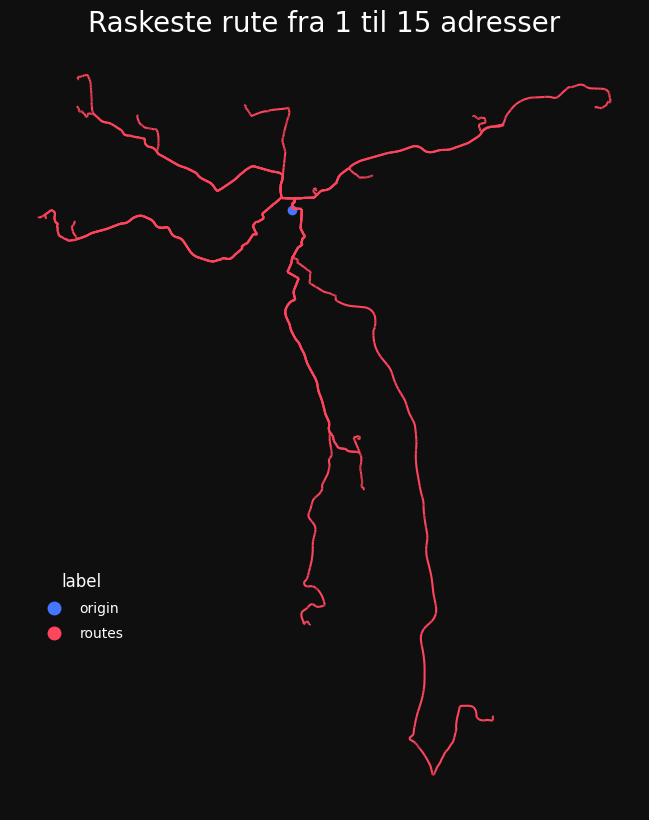

In [39]:
m = sg.ThematicMap(routes, origin, size=10)
m.black = True
m.title = "Raskeste rute fra 1 til 15 adresser"
m.plot()

## Finn raskeste k ruter
k = antall

origin  destination    minutes   k  \
0  2470929      2538349   8.977744   1   
1  2470929      2538349   9.019577   2   
2  2470929      2538349  10.702815   3   
3  2470929      2538349  11.393830   4   
4  2470929      2538349  11.659811   5   
5  2470929      2538349  12.295612   6   
6  2470929      2538349  12.971575   7   
7  2470929      2538349  13.700938   8   
8  2470929      2538349  13.920801   9   
9  2470929      2538349  14.068021  10   

                                            geometry  
0  MULTILINESTRING Z ((263586.600 6651120.600 47....  
1  MULTILINESTRING Z ((263586.600 6651120.600 47....  
2  MULTILINESTRING Z ((264335.060 6652126.070 102...  
3  MULTILINESTRING Z ((262861.600 6650719.100 23....  
4  MULTILINESTRING Z ((263586.600 6651120.600 47....  
5  MULTILINESTRING Z ((263586.600 6651120.600 47....  
6  MULTILINESTRING Z ((263586.600 6651120.600 47....  
7  MULTILINESTRING Z ((263586.600 6651120.600 47....  
8  MULTILINESTRING Z ((263586.600 6651120.600 47....  
9  MULTILINESTRING Z ((263586.600 6651120.600 47....

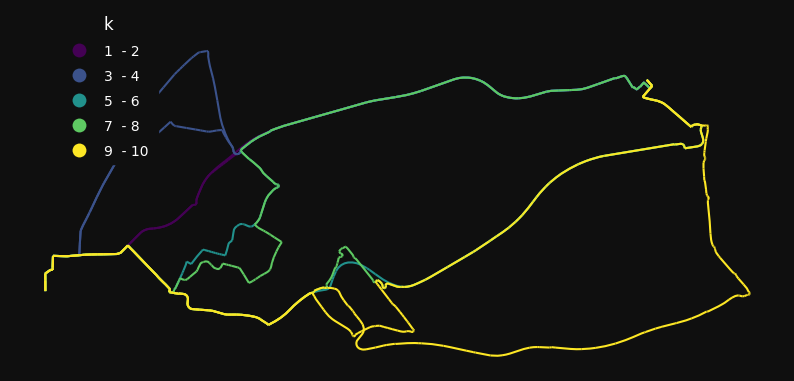

In [40]:
p1, p2 = bygg.loc[[2_470_929]], bygg.loc[[2_538_349]]

k_routes = nwa.get_k_routes(p1, p2, k=10, drop_middle_percent=1)

sg.qtm(k_routes, "k")

k_routes

Men kan stille strengere krav til hvor ulike rutene skal være. 

Med drop_middle_percent=50, fjernes midteste halvdel av ruta fra nettverket (midlertidig) før neste rute skal finnes.

/home/jovyan/arealrek/.venv/lib/python3.10/site-packages/sgis/maps/map.py:220: UserWarning: Could not create 5 classes.
  warnings.warn(f"Could not create {self._k} classes.")


origin  destination    minutes  k  \
0  2470929      2538349   8.977744  1   
1  2470929      2538349  12.295612  2   
2  2470929      2538349  15.386203  3   
3  2470929      2538349  17.419792  4   
4  2470929      2538349  19.936433  5   
5  2470929      2538349  25.519504  6   

                                            geometry  
0  MULTILINESTRING Z ((263586.600 6651120.600 47....  
1  MULTILINESTRING Z ((263586.600 6651120.600 47....  
2  MULTILINESTRING Z ((263586.600 6651120.600 47....  
3  MULTILINESTRING Z ((263586.600 6651120.600 47....  
4  MULTILINESTRING Z ((266960.510 6651263.890 116...  
5  MULTILINESTRING Z ((269773.300 6651532.900 122...

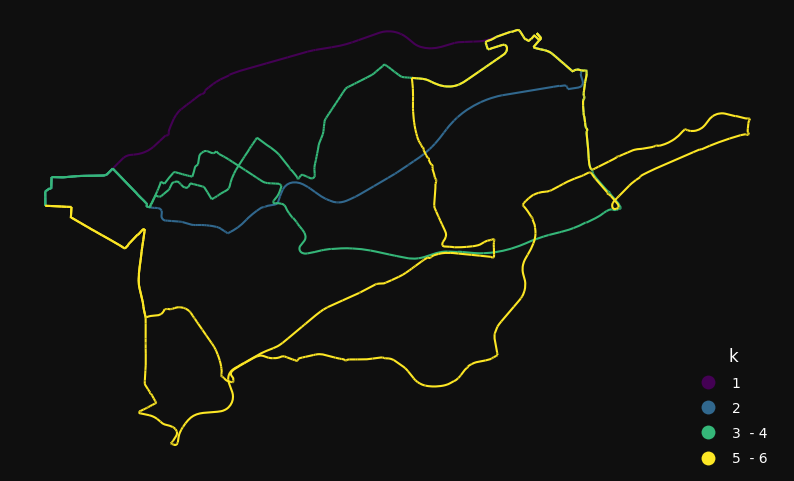

In [41]:
k_routes = nwa.get_k_routes(p1, p2, k=10, drop_middle_percent=50)

sg.qtm(k_routes, "k")

k_routes

Her fant man bare seks ulike ruter. Med drop_middle_percent=100, finner man bare én rute:

origin  destination   minutes  k  \
0  2470929      2538349  8.977744  1   

                                            geometry  
0  MULTILINESTRING Z ((263586.600 6651120.600 47....

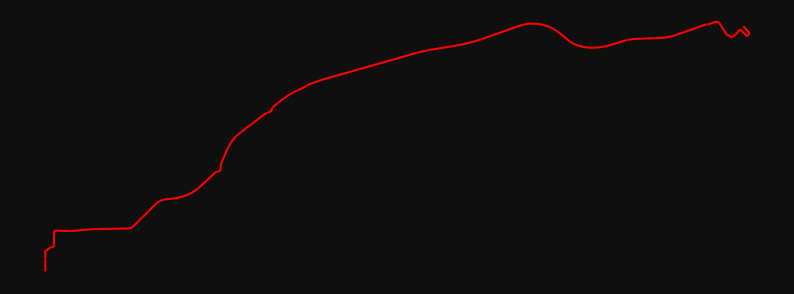

In [42]:
k_routes = nwa.get_k_routes(p1, p2, k=10, drop_middle_percent=100)

sg.qtm(k_routes, "k", color="red")

k_routes